# Timeseries tutorial
The goal of this notebook is to use the trained AIT model to calculate expected energy levels based on field data. First we will load in and clean the data and after the expected energy is calculated, we will create comparitive visualizations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [2]:
from pvops.timeseries import preprocess
from pvops.timeseries.models import linear, iec, AIT
from pvops.text2time import utils as t2t_utils, preprocess as t2t_preprocess

## Load in data

In [3]:
example_OMpath = os.path.join('example_data', 'example_om_data2.csv')
example_prodpath = os.path.join('example_data', 'example_prod_with_covariates.csv')
example_metapath = os.path.join('example_data', 'example_metadata2.csv')

In [4]:
prod_data = pd.read_csv(example_prodpath, on_bad_lines='skip', engine='python')

In [5]:
prod_data.head(5)

,date,randid,generated_kW,expected_kW,irrad_poa_Wm2,temp_amb_C,wind_speed_ms,temp_mod_C
0,2018-04-01 07:00:00,R15,0.475,0.527845,0.02775,16.570,4.2065,14.1270
1,2018-04-01 08:00:00,R15,1332.547,1685.979445,87.91450,16.998,4.1065,15.8610
2,2018-04-01 09:00:00,R15,6616.573,7343.981135,367.90350,20.168,4.5095,24.5745
3,2018-04-01 10:00:00,R15,8847.800,10429.876422,508.28700,21.987,4.9785,30.7740
4,2018-04-01 11:00:00,R15,11607.389,12981.228814,618.79450,23.417,4.6410,35.8695


In [6]:
metadata = pd.DataFrame()
metadata['randid'] = ['R15', 'R10']
metadata['dcsize'] = [25000, 25000]
metadata.head()

,randid,dcsize
0,R15,25000
1,R10,25000


### Column dictionaries
Create production and metadata column dictionary with format {pvops variable: user-specific column names}. This establishes a connection between the user's data columns and the pvops library.


In [7]:
prod_col_dict = {'siteid': 'randid', 
                 'timestamp': 'date', 
                 'powerprod': 'generated_kW',
                 'energyprod': 'generated_kW',
                 'irradiance':'irrad_poa_Wm2',
                 'temperature':'temp_amb_C', # Optional parameter, used by one of the modeling structures
                 'baseline': 'AIT', #user's name choice for new column (baseline expected energy defined by user or calculated based on IEC)
                 'dcsize': 'dcsize', #user's name choice for new column (System DC-size, extracted from meta-data)
                 'compared': 'Compared',#user's name choice for new column
                 'energy_pstep': 'Energy_pstep', #user's name choice for new column
                 'capacity_normalized_power': 'capacity_normalized_power', #user's name choice for new column
}

metad_col_dict = {'siteid': 'randid',
                  'dcsize': 'dcsize'}

## Data Formatting

Use the `prod_date_convert` function to convert date information to python datetime objects and use `prod_nadate_process` to handle data entries with no date information - here we use `pnadrop=True` to drop such entries. 

In [8]:
prod_data_converted = t2t_preprocess.prod_date_convert(prod_data, prod_col_dict)
prod_data_datena_d, _ = t2t_preprocess.prod_nadate_process(prod_data_converted, prod_col_dict, pnadrop=True)

Assign production data index to timestamp data, using column dictionary to translate to user columns.

In [9]:
prod_data_datena_d.index = prod_data_datena_d[prod_col_dict['timestamp']]

min(prod_data_datena_d.index), max(prod_data_datena_d.index)

(Timestamp('2018-04-01 07:00:00'), Timestamp('2019-03-31 18:00:00'))

## Data Preprocessing

Preprocess data with `prod_inverter_clipping_filter` using the threshold model. This adds a mask column to the dataframe where `True` indicates a row to be removed by the filter.

In [10]:
masked_prod_data = preprocess.prod_inverter_clipping_filter(prod_data_datena_d, prod_col_dict, metadata, metad_col_dict, 'threshold', freq=60)

filtered_prod_data = masked_prod_data[masked_prod_data['mask'] == False].copy()
del filtered_prod_data['mask']

print(f"Detected and removed {sum(masked_prod_data['mask'])} rows with inverter clipping.")

Detected and removed 24 rows with inverter clipping.


Visualize the power signal versus covariates (irradiance, ambient temp, wind speed) for one site

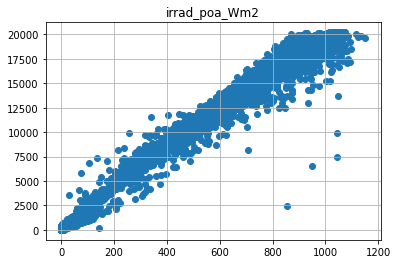

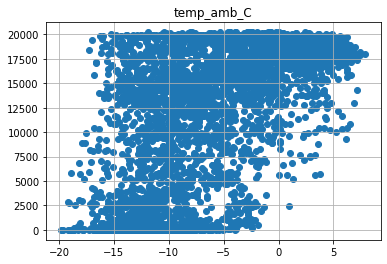

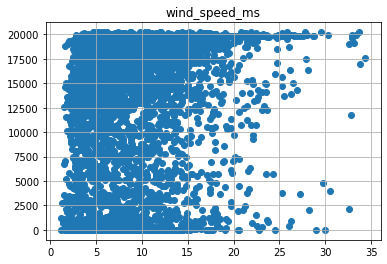

In [11]:
temp = filtered_prod_data[filtered_prod_data['randid'] == 'R10']
for xcol in ['irrad_poa_Wm2', 'temp_amb_C', 'wind_speed_ms']:
    plt.scatter(temp[xcol], temp[prod_col_dict['powerprod']])
    plt.title(xcol)
    plt.grid()
    plt.show()

Add a dcsize column to production data and populate using site metadata.

In [12]:
filtered_prod_data.head(5)
# metad.to_dict()

,date,randid,generated_kW,expected_kW,irrad_poa_Wm2,temp_amb_C,wind_speed_ms,temp_mod_C
date,,,,,,,,
2018-04-01 07:00:00,2018-04-01 07:00:00,R15,0.475,0.527845,0.02775,16.570,4.2065,14.1270
2018-04-01 08:00:00,2018-04-01 08:00:00,R15,1332.547,1685.979445,87.91450,16.998,4.1065,15.8610
2018-04-01 09:00:00,2018-04-01 09:00:00,R15,6616.573,7343.981135,367.90350,20.168,4.5095,24.5745
2018-04-01 10:00:00,2018-04-01 10:00:00,R15,8847.800,10429.876422,508.28700,21.987,4.9785,30.7740
2018-04-01 11:00:00,2018-04-01 11:00:00,R15,11607.389,12981.228814,618.79450,23.417,4.6410,35.8695


In [13]:
# Create 'dcsize' column first with site IDs
filtered_prod_data[prod_col_dict['dcsize']] = filtered_prod_data[prod_col_dict['siteid']]

# prepare dictionary for replace function
metad = metadata.copy()
metad.set_index('randid',inplace = True)

# replace site IDs with corresponding DC size
filtered_prod_data.replace(metad.to_dict(), inplace=True)

Visualize energy production for a specific site

<AxesSubplot: xlabel='date'>

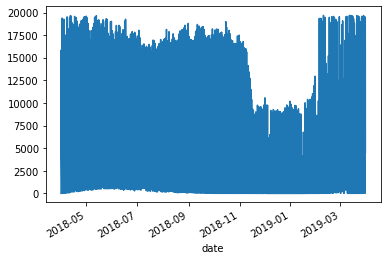

In [14]:
filtered_prod_data.loc[filtered_prod_data['randid'] == 'R15',prod_col_dict['energyprod']].plot()

Drop rows where important columns are na

In [15]:
model_prod_data = filtered_prod_data.dropna(subset=['irrad_poa_Wm2', 'temp_amb_C', 'wind_speed_ms', 'dcsize', prod_col_dict['energyprod']])
model_prod_data.head(5)

,date,randid,generated_kW,expected_kW,irrad_poa_Wm2,temp_amb_C,wind_speed_ms,temp_mod_C,dcsize
date,,,,,,,,,
2018-04-01 07:00:00,2018-04-01 07:00:00,R15,0.475,0.527845,0.02775,16.570,4.2065,14.1270,25000
2018-04-01 08:00:00,2018-04-01 08:00:00,R15,1332.547,1685.979445,87.91450,16.998,4.1065,15.8610,25000
2018-04-01 09:00:00,2018-04-01 09:00:00,R15,6616.573,7343.981135,367.90350,20.168,4.5095,24.5745,25000
2018-04-01 10:00:00,2018-04-01 10:00:00,R15,8847.800,10429.876422,508.28700,21.987,4.9785,30.7740,25000
2018-04-01 11:00:00,2018-04-01 11:00:00,R15,11607.389,12981.228814,618.79450,23.417,4.6410,35.8695,25000


## Dynamic linear modeling

Here we use the AIT model to calculate expected energy based on field data. This is appended to model_prod_data as a new column named 'AIT'.

In [16]:
model_prod_data = AIT.AIT_calc(model_prod_data, prod_col_dict)

The fit has an R-squared of -569972861.7979063 and a log RMSE of 9.515344605202777


## Visualize results

We visualize the measured hourly energy, our pre-trained model's expected energy, and the results of a partner-produced expected energy over various time-scales.

In [17]:
# defining a plotting utility function
def plot(data, randid, from_idx=0, to_idx=1000):
    data.copy()
    # Just making the visualization labels better here.. for this example's data specifically.
    data.rename(columns={'generated_kW': 'Measured Energy',
                         'AIT': 'Our Pre-trained Model',
                         'expected_kW': 'Partner Expected Energy'}, inplace=True)
    data[data['randid']==randid][['Measured Energy', 'Our Pre-trained Model', 'Partner Expected Energy']].iloc[from_idx:to_idx].plot(figsize=(12,6))

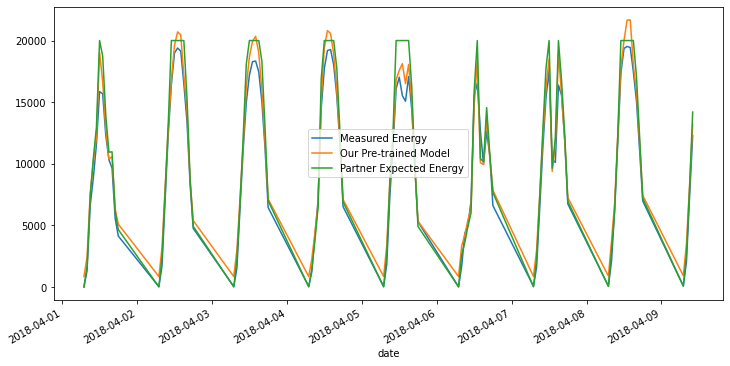

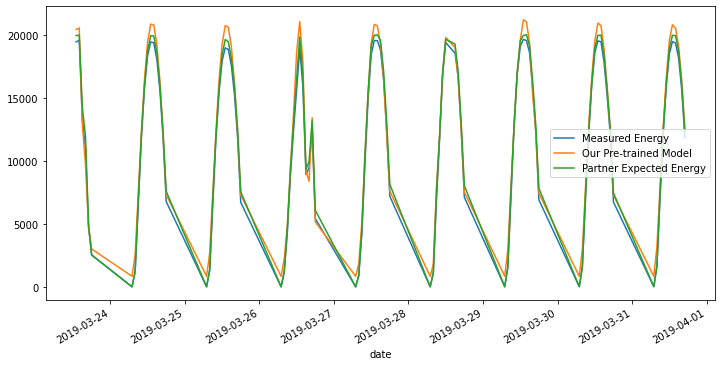

In [18]:
plot(model_prod_data, "R15", from_idx=0, to_idx=100)
plot(model_prod_data, "R15", from_idx=-100, to_idx=-1)

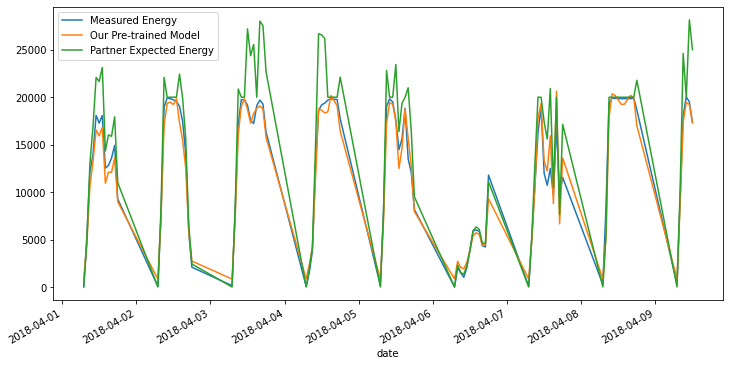

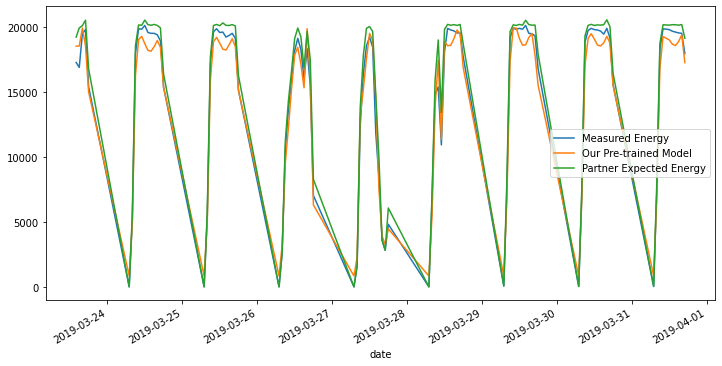

In [19]:
plot(model_prod_data, "R10", from_idx=0, to_idx=100)
plot(model_prod_data, "R10", from_idx=-100, to_idx=-1)